In [19]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import clear_output
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tabulate import tabulate

%matplotlib inline

Cartesian = lambda x,y: np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def Cluster(Z,Y,plot = True):

    data = np.column_stack((Z, Y))
    centers = Cartesian(np.array([-25,-8,8,25]),np.array([-25,-8,8,25]))
    kmeans = KMeans(n_clusters=16, init=centers)
    kmeans.fit(data)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    if plot:
      plt.figure(figsize=(12, 7)) 
      plt.title(f"Num of antennas: {Z.shape[0]}") 
      plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis') 
      plt.scatter(centers[:, 0], centers[:, 1], marker='X',c='red', s=100, label='Centers') 
      plt.grid() 
      plt.show() 

    return data, labels

def SmartPadding(Z,Y,i):
    # The function get 
    Z,Y = np.squeeze(Z[i][0]), np.squeeze(Y[i][0])
    data, labels = Cluster(Z,Y, plot = False)
    
    pad_data = None

    for l in range(16):
        labeled_data = np.vstack((data[labels == l], np.zeros((64 - np.sum(labels == l), 2))))
        pad_data = np.vstack((pad_data, labeled_data)) if pad_data is not None else labeled_data

    # does not have to be flatten   
    return pad_data.flatten()

def NaivePadding(Z,Y,i):
    data = np.column_stack(np.squeeze(Z[i][0]), np.squeeze(Y[i][0]))
    zeros = np.zeros((2048-data.shape[0],2))
    return np.vstack((data,zeros)).flatten()

def CreateData():
    YantData = scipy.io.loadmat('/content/drive/MyDrive/AntData/YantData.mat')['YantData']
    ZantData = scipy.io.loadmat('/content/drive/MyDrive/AntData/ZantData.mat')['ZantData']

    data_list = [SmartPadding(ZantData, YantData, i) for i in tqdm(range(ZantData.shape[0]))]

    return np.array(data_list)


In [3]:
Data = CreateData()
cost = scipy.io.loadmat('/content/drive/MyDrive/AntData/cost.mat')['cost']

100%|██████████| 103201/103201 [04:56<00:00, 347.60it/s]


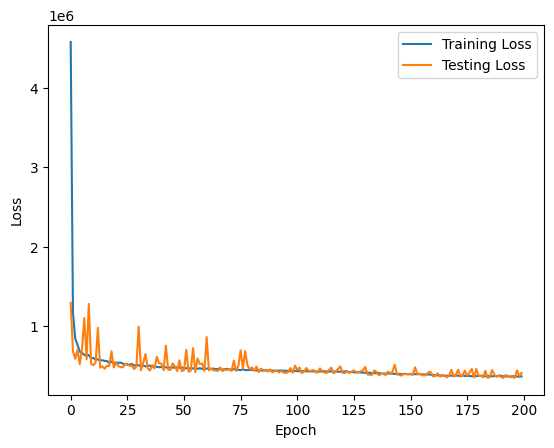

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Data, cost, test_size=0.2, random_state=42)

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2048, activation='relu', input_shape=(2048,)),  
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

# Get the training and testing loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

clear_output(wait = True)

# Plot the training and testing loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Make predictions on training and testing data
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Calculate percentage errors
train_percentage_errors = np.abs((train_predictions - y_train) / y_train) * 100
test_percentage_errors = np.abs((test_predictions - y_test) / y_test) * 100

train_result = ['Train',np.mean(train_percentage_errors)]
test_result = ['Test',np.mean(test_percentage_errors)]

for i in [1,5,10,15,25,50]:
  train_result.append(100 * np.sum(train_percentage_errors <= i)/len(train_percentage_errors))
  test_result.append(100 * np.sum(test_percentage_errors <= i)/len(test_percentage_errors))

clear_output(wait = True)

print(tabulate([train_result, test_result], headers=['MPE', '< 1%','< 5%','< 10%','< 15%','< 25%','< 50%'], tablefmt='orgtbl'))

|       |     MPE |     <1% |     <5% |    <10% |    <15% |    <25% |    <50% |
|-------+---------+---------+---------+---------+---------+---------+---------|
| Train | 25.7584 | 11.6667 | 48.6192 | 68.9547 | 77.4213 | 84.1134 | 89.5724 |
| Test  | 14.8679 | 11.482  | 47.4638 | 68.3736 | 76.9246 | 83.9688 | 89.4579 |
